In [17]:
from system import *
from agents import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np
import pandas as pd
import random
import math
from tqdm import tqdm

In [20]:
dqn_agent = DQN()
dqn_agent.train(num_tickers=3, episodes_per_ticker=4)

100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


In [22]:
h = dqn_agent.history
h

,date,ticker,rewards,actions,returns,prices,episode
0,2014-01-06,A,0.994409,1,-0.004919,40.515022,1
1,2014-01-07,A,0.891354,1,0.009310,41.094421,1
2,2014-01-08,A,-0.000428,0,0.004634,41.766811,1
3,2014-01-09,A,0.000000,0,0.004634,41.781116,1
4,2014-01-10,A,-0.000000,0,0.004634,42.153076,1
...,...,...,...,...,...,...,...
12055,2017-12-22,AAP,0.828727,1,-0.001734,100.550003,4
12056,2017-12-26,AAP,-1.180612,1,-0.001690,101.959999,4
12057,2017-12-27,AAP,-0.026094,1,-0.001758,99.769997,4
12058,2017-12-28,AAP,-0.000948,1,-0.001759,99.709999,4


In [23]:
h[h.ticker == 'A'].episode.unique()

array([1, 2, 3, 4])

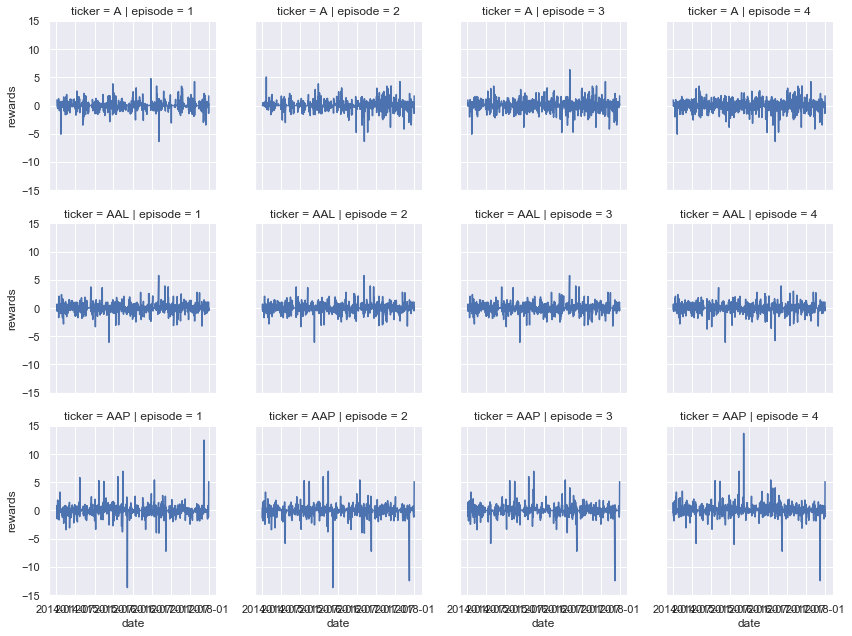

In [27]:
q = sns.FacetGrid(data=h, row='ticker', col='episode')
q.map(sns.lineplot, 'date', 'rewards')

In [32]:
a2c_agent = A2C()
a2c_agent.train(num_tickers=1, episodes_per_ticker=1)

100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


In [30]:
ddpg_agent = DDPG()
ddpg_agent.train(num_tickers=1, num_episodes=1)

100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


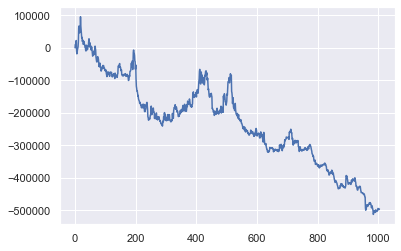

In [357]:
h = ddpg_agent.history
h['returns'].plot()
# h[h.episode == 1]

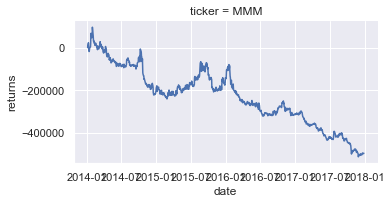

In [358]:
q = sns.FacetGrid(ddpg_agent.history, col='ticker', col_wrap=3, aspect=1.61)
q.map(sns.lineplot, 'date', 'returns')

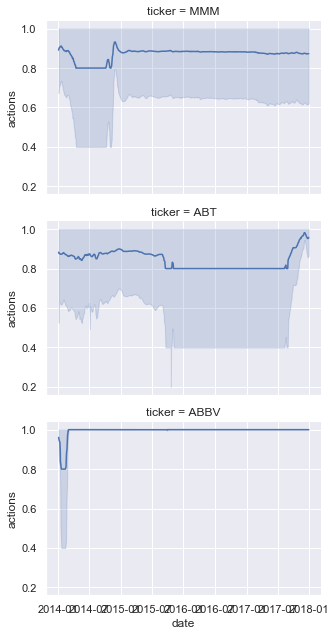

In [317]:
q = sns.FacetGrid(ddpg_agent.history, row='ticker', aspect=1.61)
q.map(sns.lineplot, 'date', 'actions')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f501d23c750>],
      dtype=object)

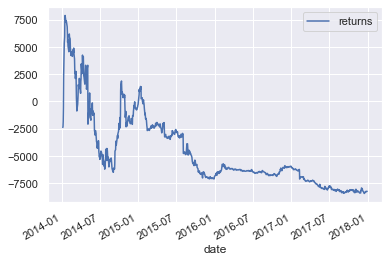

In [296]:
h[h.episode == 6].plot(x='date', y='returns', subplots=True)

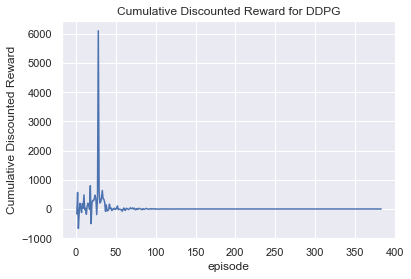

In [85]:
ddpg_agent.plot_cumulative_discounted_rewards()

In [46]:
ddpg_agent.history.tail(10)

,date,ticker,rewards,actions,returns,prices,episode,discount_factor,discounted_future_reward
Date,,,,,,,,,
2017-12-14,2017-12-14,TSCO,-48.638628,-1.0,4824.383355,66.779999,383,3.093266e-09,-1.504522e-07
2017-12-15,2017-12-15,TSCO,-28.920339,-1.0,4664.174877,68.419998,383,3.093266e-09,-8.945829e-08
2017-12-18,2017-12-18,TSCO,-49.614682,-1.0,4403.179110,69.199997,383,3.093266e-09,-1.534714e-07
2017-12-19,2017-12-19,TSCO,-84.376265,-1.0,3925.576294,70.500000,383,3.093266e-09,-2.609982e-07
2017-12-20,2017-12-20,TSCO,-47.362934,-1.0,3669.591833,72.970001,383,3.093266e-09,-1.465061e-07
2017-12-21,2017-12-21,TSCO,-3.009030,-1.0,3653.986157,74.389999,383,3.093266e-09,-9.307729e-09
2017-12-22,2017-12-22,TSCO,-27.235636,-1.0,3512.151060,74.480003,383,3.093266e-09,-8.424706e-08
2017-12-26,2017-12-26,TSCO,16.013655,-1.0,3583.217089,75.300003,383,3.093266e-09,4.953449e-08
2017-12-27,2017-12-27,TSCO,-7.980451,-1.0,3548.996180,74.879997,383,3.093266e-09,-2.468566e-08


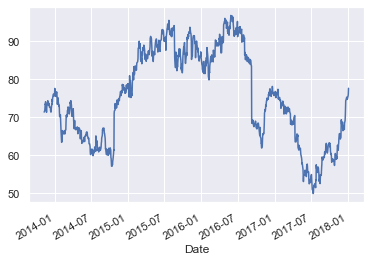

In [50]:
e = ContinuousTradingEnv('TSCO')
e.prices.plot()

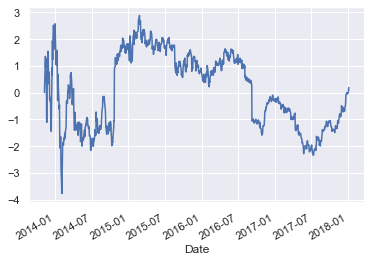

In [51]:
e.prices_normalized.plot()

In [ ]:
training_history = pd.DataFrame()

In [363]:
with open("filtered_tickers.txt", "r") as src:
    filtered_tickers = src.read().split("\n")

# agent_constructors = [DQN, A2C, DDPG]
# agent_constructors = [A2C, DDPG]
agent_constructors = [DDPG]
# training_history = pd.DataFrame()
for con in agent_constructors:
    for t in tqdm(filtered_tickers):
        a = con()
#         e = a.ENV_CONSTRUCTOR(ticker=t, mode="dev")
        e = a.ENV_CONSTRUCTOR(ticker=t, mode="train")
        h = a.run_episode(e)
        h['agent'] = a.name
        h['t'] = range(len(h))
        training_history = pd.concat((training_history, h))


100%|██████████| 428/428 [16:28<00:00,  2.31s/it]


In [364]:
h = training_history
# h[h.ticker == 'MMM'].returns.plot()

In [366]:
s = 'MMM'
h[h.ticker == s]

,date,ticker,rewards,actions,returns,prices,agent,t
Date,,,,,,,,
2014-01-06,2014-01-06,MMM,-0.000000,0.0,0.000000,137.630005,Deep Q-Network,0
2014-01-07,2014-01-07,MMM,21.330622,-1.0,10199.890137,137.649994,Deep Q-Network,1
2014-01-08,2014-01-08,MMM,12.447086,-1.0,12026.845880,136.630005,Deep Q-Network,2
2014-01-09,2014-01-09,MMM,-0.019151,0.0,5960.941284,136.449997,Deep Q-Network,3
2014-01-10,2014-01-10,MMM,63.109240,-1.0,8995.432037,136.179993,Deep Q-Network,4
...,...,...,...,...,...,...,...,...
2017-12-21,2017-12-21,MMM,-9.169934,1.0,9390.958968,234.779999,DDPG,999
2017-12-22,2017-12-22,MMM,13.393221,1.0,9979.336612,234.729996,DDPG,1000
2017-12-26,2017-12-26,MMM,13.956440,1.0,10592.228953,235.449997,DDPG,1001


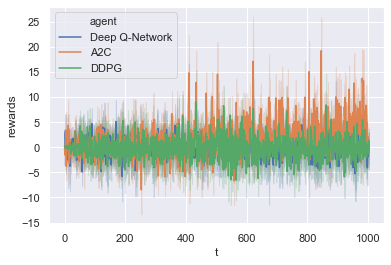

In [368]:
sns.lineplot('t', 'rewards', hue='agent', data=h)

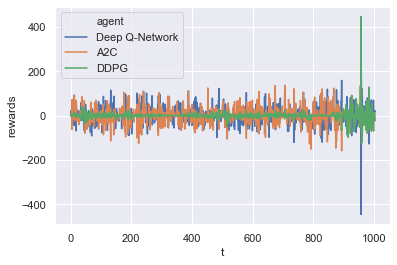

In [371]:
sns.lineplot('t', 'rewards', hue='agent', data=h[h.ticker == 'MMM'])

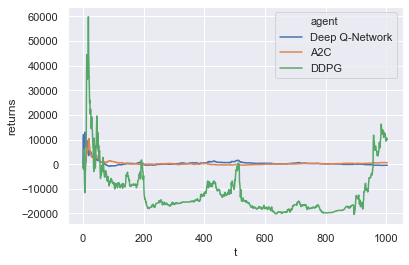

In [372]:
sns.lineplot('t', 'returns', hue='agent', data=h[h.ticker == 'MMM'])

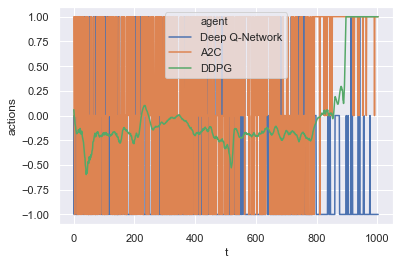

In [373]:
sns.lineplot('t', 'actions', hue='agent', data=h[h.ticker == 'MMM'])

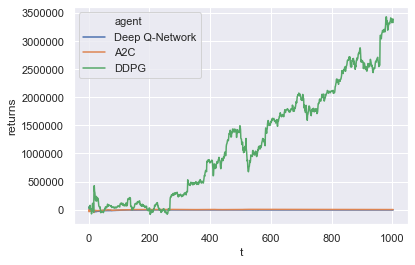

In [376]:
sns.lineplot('t', 'returns', hue='agent', data=h[h.ticker == 'AMZN'])

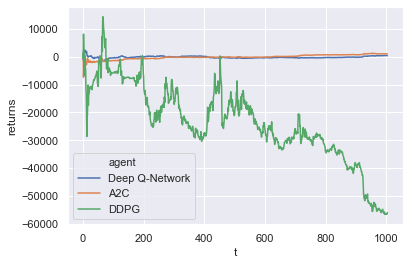

In [378]:
sns.lineplot('t', 'returns', hue='agent', data=h[h.ticker == 'ABBV'])